```
conda install -c gurobi gurobi
```

In [37]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import copy

In this tutorial, I'll use the Gurobi solver. Students and academics can register for a free license [here](https://www.gurobi.com/academia/academic-program-and-licenses/). 

Pyomo also suports several other solvers. The solvers available for your version of pyomo can be listed by running the following command in an anaconda prompt using an environment with pyomo installed.
```
pyomo help --solvers
```

# Simple Example: Simple Piecewise Linear Approx

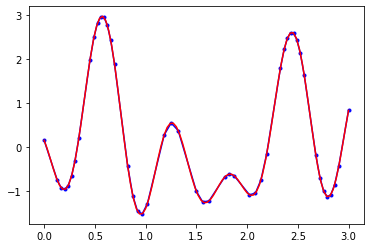

In [84]:
def func(x):
    return np.sin(3*x) + np.sin(10*x+2) + np.sin(7*x+4)

#A Simple nonlinear optimization to determine the best placement of linear regions.
nRegions = 50

def optimizeRegions(xs):
    res = 200
    xs = np.insert(xs, 0, 0)
    xs = np.append(xs, 3)
    xs = np.sort(xs)
    
    interpFunc = interp1d(xs,func(xs))
    
    err = sum([(func(x) - interpFunc(x))**2 for x in np.linspace(0,3,res)])
    
    if min(xs) < 0:
        err += -1 * min(xs)
    if max(xs) > 3:
        err += max(xs) - 3
    
    return err

xs = minimize(optimizeRegions,1.15*np.arctan(2*np.linspace(0.5,2.5,nRegions-2)-3)+1.5).x
xs = np.insert(xs, 0, 0)
xs = np.append(xs, 3)
xs = np.sort(xs)

plaXs = copy.deepcopy(xs)
plaYs = func(plaXs)
plt.plot(plaXs,plaYs,"b.")
plt.plot(plaXs,plaYs,"b")

xs = np.linspace(0,3,100)
ys = func(xs)
plt.plot(xs,ys,"r")

$Maximize\left( y = \sum_{i \in I} W_i y_i \right)$

s.t. 

$\sum_{i \in I} W_i = 1$

$W_i \geq 0 \ \ \ \ \forall \ i \ \in \ I$

$W_i \leq A_i$

$\sum_{i \in I} A_i = 2$

$A_i \leq A_{i-1} + A_{i+1}$

In [86]:
model = gp.Model()

I = range(len(plaXs))

W = model.addVars(I, vtype=gp.GRB.CONTINUOUS, name="W")
A = model.addVars(I, vtype=gp.GRB.BINARY, name="A")

model.setObjective(
    sum([W[i] * plaYs[i] for i in I]),
    gp.GRB.MAXIMIZE
)

weightSumConstr = model.addConstr(sum([W[i] for i in I]) == 1)

weightNonNegConstr = []
for i in I:
    weightNonNegConstr.append(model.addConstr(W[i] >= 0))
    
weightActivationConstr = []
for i in I:
    weightActivationConstr.append(model.addConstr(W[i] <= A[i]))
    
twoActivationConst = model.addConstr(sum([A[i] for i in I]) <= 2)

neighborConstr = []
for i in I:
    lhs = A[i]
    rhs = 0
    if (i-1) >= 0:
        rhs += A[i-1]
    if (i+1) < len(A):
        rhs += A[i+1]
            
    neighborConstr.append(model.addConstr(lhs <= rhs))
    
model.NumStart = 1
model.update()
model.params.StartNumber = 0
W[0].Start = 1.0
for i in range(1,len(W)):
    W[i].Start = 0.0

A[0].Start = 1
A[1].Start = 1
for i in range(2,len(A)):
    A[i].Start = 0
    
model.optimize()

for i in range(len(W)):
    print("W{} = {}\t{}\t{}".format(i,W.values()[i].X,A.values()[i].X,plaYs[i]))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 152 rows, 100 columns and 398 nonzeros
Model fingerprint: 0x6fe4a16c
Variable types: 50 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]

Loaded user MIP start with objective 0.152495

Presolve removed 50 rows and 0 columns
Presolve time: 0.00s
Presolved: 102 rows, 100 columns, 350 nonzeros
Variable types: 50 continuous, 50 integer (50 binary)

Root relaxation: objective 2.955288e+00, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0 

In [16]:
model = gp.Model()

ANSWER = 40

x = model.addVar(vtype=gp.GRB.CONTINUOUS,name="x")

model.setObjective(
    40 * x,
    gp.GRB.MAXIMIZE
)

model.addConstr( x <= 40)

x.setAttr("PStart",ANSWER)

model.setParam(gp.GRB.Param.LPWarmStart, 1)

model.optimize()
print("\n\nx =",x.x)

Warning on update mode = 1 after new variables or constraints added:
Setting LP warm start basis or start ignored
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 1 columns and 1 nonzeros
Model fingerprint: 0x3c3f69f8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 4e+01]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.600000000e+03


x = 40.0
